In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error, explained_variance_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

VERSION = 'v1'
# Cargar los datos (reemplaza 'path_to_file' con la ruta real)
movies = pd.read_csv(f'./data/train_data/{VERSION}/Movies.csv')
film_details = pd.read_csv(f'./data/train_data/{VERSION}/FilmDetails.csv')


In [2]:
from model.pre_process import pre_process
# === 2. Limpieza y preparación ===
# Combinar tablas por 'id'
data = pd.merge(movies, film_details, on='id')
data = pre_process(data, True)

# Escalar variables numéricas
#scaler = StandardScaler()
#data[['budget_usd', 'revenue_usd', 'vote_count', 'runtime_hour', 'runtime_min']] = scaler.fit_transform(
#  data[['budget_usd', 'revenue_usd', 'vote_count', 'runtime_hour', 'runtime_min']]
#)
data

/app/model/pre_process.py:37: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  genres_dummies = genres_dummies.groupby(genres_dummies.columns, axis=1).any()


,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,History,Horror,...,War,Western,budget_usd,director_encoded,language_encoded,revenue_usd,runtime_hour,runtime_min,user_score,vote_count
0,False,False,False,False,True,True,False,False,False,False,...,False,False,25000000.0,699,6,28341469.0,2,22,8.7,27070
1,False,False,False,False,True,True,False,False,False,False,...,False,False,6000000.0,690,6,245066411.0,2,55,8.7,20563
2,False,False,False,False,True,True,False,False,False,False,...,False,False,13000000.0,690,6,102600000.0,3,22,8.6,12403
3,False,False,False,False,False,True,False,False,True,False,...,True,False,22000000.0,2157,6,321365567.0,3,15,8.6,15810
4,False,False,False,False,False,True,False,False,False,False,...,False,False,397751.0,2074,6,4360000.0,1,37,8.5,8611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9712,True,True,False,False,False,False,False,False,False,False,...,False,False,44000000.0,1953,6,29725663.0,1,57,3.3,839
9713,True,False,False,False,False,False,False,True,False,True,...,False,False,20000000.0,2312,6,12693645.0,1,38,3.3,602
9714,False,False,False,True,False,False,False,False,False,False,...,False,False,25000000.0,6,6,34816824.0,1,27,3.2,1021
9715,True,False,False,False,False,False,False,False,False,True,...,False,False,12000000.0,2312,6,13818181.0,1,30,3.1,384


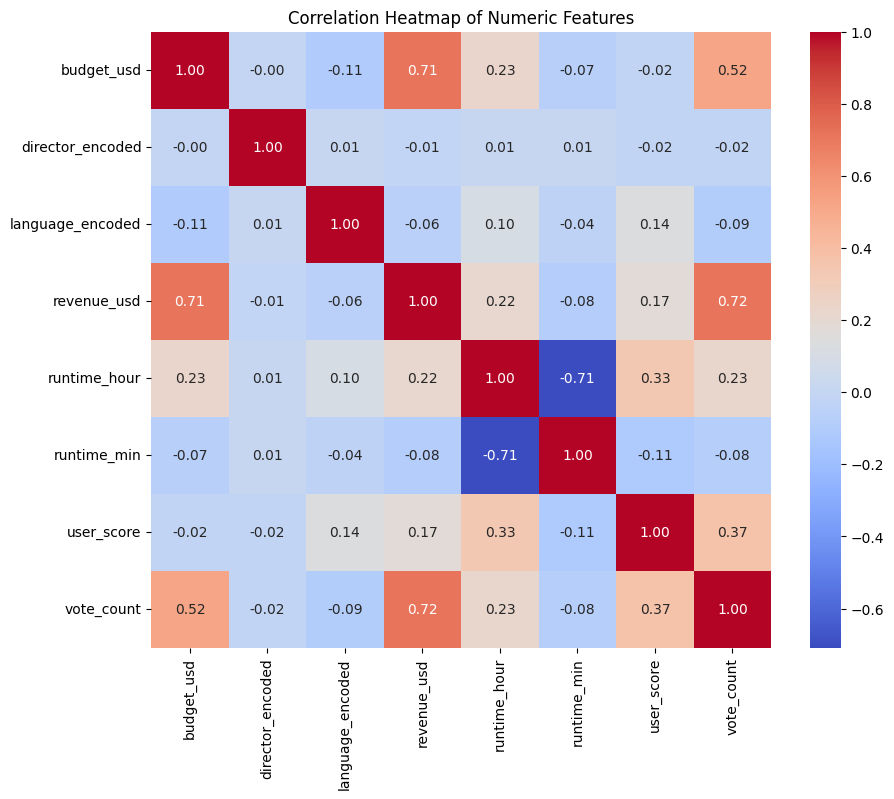

In [5]:
# Correlation heatmap for numeric features
numeric_df = data.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


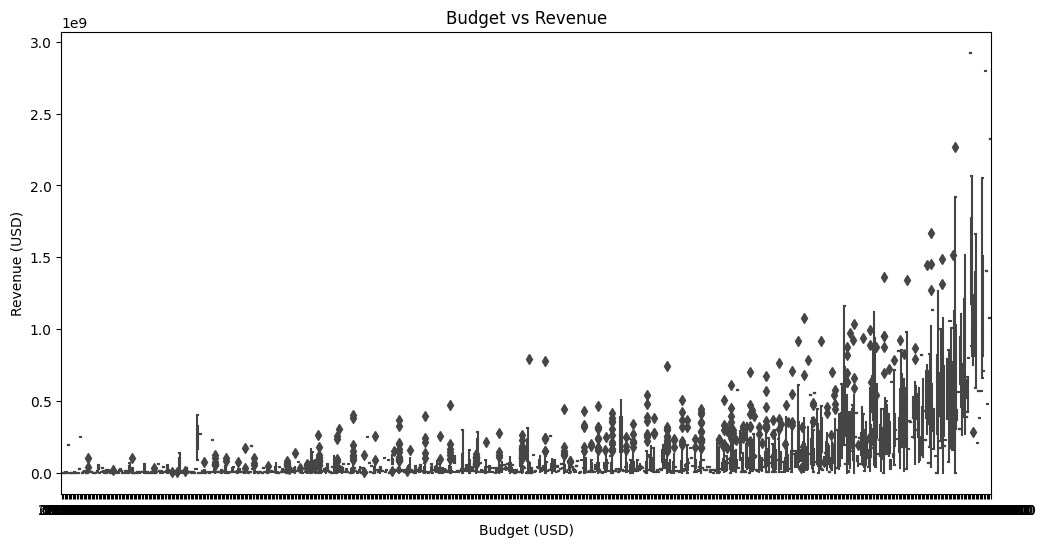

In [4]:
# Box plot of budget vs revenue
plt.figure(figsize=(12, 6))
sns.boxplot(x='budget_usd', y='revenue_usd', data=data)
plt.title('Budget vs Revenue')
plt.xlabel('Budget (USD)')
plt.ylabel('Revenue (USD)')
plt.show()

In [6]:
maxRev = data.loc[data['revenue_usd'] == data['revenue_usd'].max(), ['revenue_usd','director_encoded']]
minRev = data.loc[data['revenue_usd'] == data['revenue_usd'].min(), ['revenue_usd','director_encoded']]
print(maxRev)
print(minRev)

       revenue_usd  director_encoded
1051  2.923706e+09               928
      revenue_usd  director_encoded
7019       3491.0              1149


In [7]:
# === 3. División de datos en entrenamiento y prueba ===
# Variables predictoras y objetivo
X = data.drop(columns=['revenue_usd'])
y = data['revenue_usd']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (4902, 26)
Tamaño del conjunto de prueba: (1226, 26)


In [11]:
from sklearn.ensemble import RandomForestRegressor
# === 4. Entrenamiento del modelo ===
# Entrenar Random Forest
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

print(f"MAE: {mae}") #Un MAE(Mean Absolute Error) De 0 a ∞ más bajo significa que el modelo está haciendo predicciones más precisas.
print(f"R²: {r2}")#Coeficiente de Determinación % de la variabilidad en los datos reales es explicada por el modelo.
print("RMSE", rmse)#Indica el error promedio cuadrático. Es útil porque penaliza errores grandes más que el MAE.
print("Mediana_EA", medae) #Ayuda a reducir el impacto de valores atípicos (outliers).
print("Explained_Variance", explained_var) #Mide qué tan bien el modelo explica la variabilidad de los datos.

MAE: 47168275.25772431
R²: 0.7907731024544683
RMSE 8586073134394224.0
Mediana_EA 25669795.35
Explained_Variance 0.7908874916596351


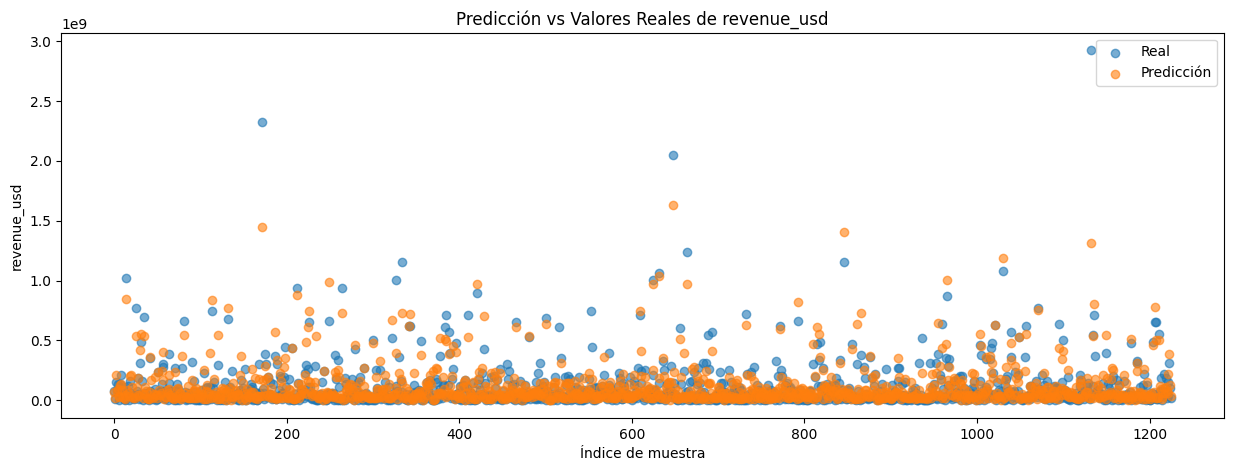

In [9]:
# === 6. Visualización de resultados ===
plt.figure(figsize=(15, 5))
plt.scatter(range(len(y_test)), y_test, label="Real", alpha=0.6)
plt.scatter(range(len(y_test)), y_pred, label="Predicción", alpha=0.6)
plt.legend()
plt.title("Predicción vs Valores Reales de revenue_usd")
plt.xlabel("Índice de muestra")
plt.ylabel("revenue_usd")
plt.show()

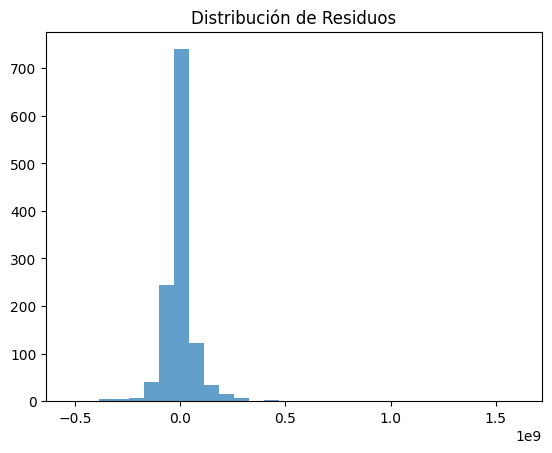

In [10]:
residuos = y_test - y_pred
plt.hist(residuos, bins=30, alpha=0.7)
plt.title("Distribución de Residuos")
plt.show()

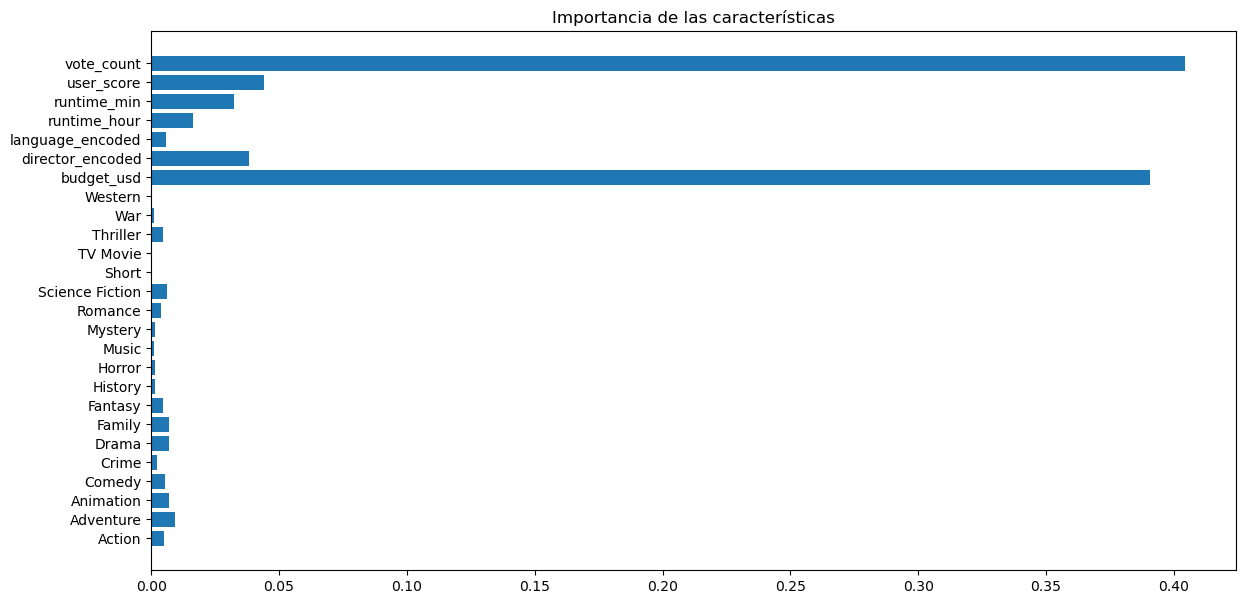

In [8]:
# Importancia de las características
importances = model.feature_importances_
features = X.columns
plt.figure(figsize=(14, 7))
plt.barh(features, importances)
plt.title("Importancia de las características")
plt.show()

In [10]:
pre_data =  pd.merge(movies, film_details, on='id')
#Datos que tengan alguna de las columnas especificadas en nulo
null_values_mask = pre_data[['genres', 'language', 'budget_usd', 'revenue_usd', 'vote_count', 'runtime_hour', 'runtime_min', 'director', 'user_score']].isnull().any(axis=1)
#Datos que tengan el budget pero no el revenue_usd en nulo (para pruebas)
test_values_mask = pre_data['revenue_usd'].isnull() & ~pre_data['budget_usd'].isnull()
#Datos que tengan el revenue_usd pero no el budget en nulo (para entrenar, pero hay que completar la columna budget)
test_values_mask2 = ~pre_data['revenue_usd'].isnull() & pre_data['budget_usd'].isnull()
#Datos que tengan el revenue_usd pero no el budget en nulo (para entrenar o para pruebas pero hay que completar ambas columnas)
test_values_mask3 = pre_data['revenue_usd'].isnull() & pre_data['budget_usd'].isnull()

null_values = pre_data[null_values_mask]
test_values = pre_data[test_values_mask]
test_values2 = pre_data[test_values_mask2]
test_values3 =  pre_data[test_values_mask3]

null_values.to_csv("./data/otherData/incomplete_data.csv", index=False)
test_values.to_csv("./otherData/no_revenue.csv", index=False)
test_values2.to_csv("./otherData/no_budget.csv", index=False)
test_values3.to_csv("./otherData/no_budget_and_revenue.csv", index=False)

print("Número de filas con al menos un valor nulo: ", null_values.shape)
print("Número de filas con revenue_usd nulo: ", test_values.shape)
print("Número de filas con budget_usd nulo: ", test_values2.shape)
print("Número de filas con revenue_usd y budget_usd nulo: ", test_values3.shape)

Número de filas con al menos un valor nulo:  (3590, 13)
Número de filas con revenue_usd nulo:  (609, 13)
Número de filas con budget_usd nulo:  (1049, 13)
Número de filas con revenue_usd y budget_usd nulo:  (1932, 13)


In [17]:
import time
# === 7. Probar modelo ===

timestamp = time.time()
raw_data = pd.read_csv('./data/test_data/no_revenue.csv')
print('Raw data shape', raw_data.shape)

#Validate columns
necesary_columns = ['genres', 'language', 'budget_usd', 'vote_count', 'runtime_hour', 'runtime_min', 'director', 'user_score']

is_valid_columns = all(col in raw_data.columns for col in necesary_columns)
if(not is_valid_columns):
    print("Invalid format")

pp_data = pre_process(raw_data)
if pp_data.shape[0] > 0:
    predictions = model.predict(pp_data)
    result = raw_data
    result['revenue_usd'] = predictions
    result['revenue_usd'] = pd.to_numeric(result['revenue_usd'], errors='coerce')
    result.to_csv(f"./data/results/result_{timestamp}.csv", index=False)
else:
    print('no data')

Raw data shape (609, 13)


/home/jovyan/model/pre_process.py:37: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  genres_dummies = genres_dummies.groupby(genres_dummies.columns, axis=1).any()
